In [29]:
import pandas as pd
import numpy as np

# Load the data
airbnb = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


<AxesSubplot:xlabel='price', ylabel='Count'>

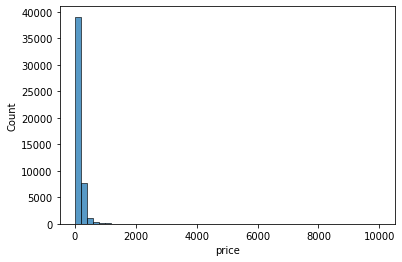

In [30]:
# Look at price variable -  it has a long tail
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.histplot(airbnb.price, bins = 50)

<AxesSubplot:xlabel='price', ylabel='Count'>

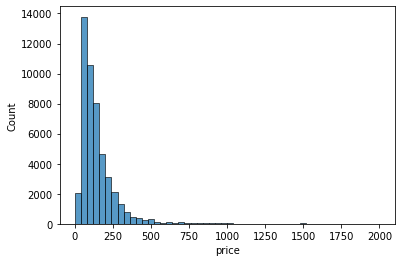

In [31]:
sns.histplot(airbnb.price[airbnb.price < 2000], bins = 50)

In [32]:
# Only select the following  features

airbnb = airbnb[['latitude',
'longitude',
'price',
'minimum_nights',
'number_of_reviews',
'reviews_per_month',
'calculated_host_listings_count',
'availability_365']]

In [33]:
airbnb.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0


In [34]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   latitude                        48895 non-null  float64
 1   longitude                       48895 non-null  float64
 2   price                           48895 non-null  int64  
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               38843 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 3.0 MB


## Question 1
* Find a feature with missing values. How many missing values does it have?

In [35]:
airbnb.isnull().sum()[airbnb.isnull().sum()>0]

reviews_per_month    10052
dtype: int64

## Question 2

What's the median (50% percentile) for variable 'minimum_nights'?


### Split the data

* Shuffle the initial dataset, use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.
* Make sure that the target value ('price') is not in your dataframe.
* Apply the log transformation to the price variable using the `np.log1p()` function.

In [36]:
airbnb.minimum_nights.describe()

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64

In [37]:
np.random.seed(42)

n = len(airbnb)

idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = airbnb.iloc[idx[:n_train]]
df_val = airbnb.iloc[idx[n_train:n_train+n_val]]
df_test = airbnb.iloc[idx[n_train+n_val:]]

print(len(df_train), len(df_val), len(df_test))

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

29337 9779 9779


## Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

In [38]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

# fill with zero first

X_train = df_train.fillna(0).values
X_val = df_val.fillna(0).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_val.dot(w)
y_pred

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

print(f"The RMSE for model with filling in zeroes for missing on validation set is {round(rmse(y_val,y_pred),2)}")

# fill with mean next

X_train = df_train.fillna(df_train.reviews_per_month.mean()).values
X_val = df_val.fillna(df_train.reviews_per_month.mean()).values

w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_val.dot(w)
y_pred

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

print(f"The RMSE for model with filling in mean of columns with missing data for missing on validation set is {round(rmse(y_val,y_pred),2)}")



The RMSE for model with filling in zeroes for missing on validation set is 0.64
The RMSE for model with filling in mean of columns with missing data for missing on validation set is 0.64


## Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

In [39]:
def prepare_X(df):
    df_num = df.fillna(0)
    X = df_num.values
    return X

def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [40]:
for r in [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=r)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, round(score,2))

0 -419.9126602662599 0.64
1e-06 -419.8627175667821 0.64
0.0001 -414.9764939426042 0.64
0.001 -375.2736539132886 0.64
0.01 -191.7838408450517 0.66
0.1 -32.56256056148664 0.68
1 -3.4992168345296957 0.68
5 -0.7033623213789353 0.68
10 -0.3512767596671551 0.68


In [41]:
print('The smallest r is 0')

The smallest r is 0


## Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)


> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.


In [42]:
scores = []

for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(seed)
    n = len(airbnb)
    idx = np.arange(n)
    np.random.shuffle(idx)

    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    df_train = airbnb.iloc[idx[:n_train]]
    df_val = airbnb.iloc[idx[n_train:n_train+n_val]]
    df_test = airbnb.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = np.log1p(df_train.price.values)
    y_val = np.log1p(df_val.price.values)
    y_test = np.log1p(df_test.price.values)

    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    # fill with zero first

    X_train = df_train.fillna(0).values
    X_val = df_val.fillna(0).values

    w0, w = train_linear_regression(X_train, y_train)

    y_pred = w0 + X_val.dot(w)
    y_pred

    print(f"The RMSE for model with seed {seed} on validation set is {round(rmse(y_val,y_pred),2)}")
    scores.append(round(rmse(y_val,y_pred),2))

scores

The RMSE for model with seed 0 on validation set is 0.65
The RMSE for model with seed 1 on validation set is 0.65
The RMSE for model with seed 2 on validation set is 0.65
The RMSE for model with seed 3 on validation set is 0.64
The RMSE for model with seed 4 on validation set is 0.64
The RMSE for model with seed 5 on validation set is 0.63
The RMSE for model with seed 6 on validation set is 0.63
The RMSE for model with seed 7 on validation set is 0.65
The RMSE for model with seed 8 on validation set is 0.65
The RMSE for model with seed 9 on validation set is 0.64


[0.65, 0.65, 0.65, 0.64, 0.64, 0.63, 0.63, 0.65, 0.65, 0.64]

In [43]:
round(np.std(scores), 3)

0.008

## Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

In [44]:
np.random.seed(9)

n = len(airbnb)
idx = np.arange(n)
np.random.shuffle(idx)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

df_train = airbnb.iloc[idx[:n_train]]
df_val = airbnb.iloc[idx[n_train:n_train+n_val]]
df_test = airbnb.iloc[idx[n_train+n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [45]:
df_train = pd.concat([df_train,df_val], axis = 0)
y_train = np.append(y_train,y_val)

In [46]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_test)
y_pred = w0 + X_val.dot(w)
score = rmse(y_test, y_pred)
    
print(r, w0, round(score,2))

10 -389.1162953973037 0.65
